# Very basic Auto-Encoder: Let's explore the performance 

We would like to explore the performance of the auto-encoder to recognize an anomaly. 

We want to explore how well the auto-encoder recognizes the anomaly, as a function of how we generate the anomalies.  Therefore we proceed as follows: we train an autoencoder with a large sample of 'normal' strings, and then we test how is the AE performance to distinguish something 'not-normal'.  To do this we test how well/bad it reproduces the not-normal strings.  We use as a classifier of normal / anomaly the MSE (mean square error) in the reproduction, and we scan on the MSE to construct a ROC curve, and therefore an Area-Under-Curve result.

If the anomaly recognition works good, then the anomalous strings should all be towards a large MSE, and then a good AUC should be achieved.  And the vice-verse.

The whole process is subtle, since it is only a research-purpose process.  One would never had this scenario with as many anomalies as normal strings.  In fact, we are also having an algorithm for producing anomalous strings, which is something would never happen in a anomaly detection scenario.

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Generate Sequence Data

In [2]:
# Normal data
first_letters =  'ABCDEF'
second_numbers = '7890'
last_letters = 'RSTVWXYZ'

# returns a string of the following format: [4 letters A-F][1 digit 0-2][3 letters QWOPZXML]
def get_random_string():
    str1 = ''.join(random.choice(first_letters) for i in range(4))
    str2 = random.choice(second_numbers)
    str3 = ''.join(random.choice(last_letters) for i in range(3))
    return str1+str2+str3

In [3]:
# Fake data
first_letters2 =  'ABCDEFGH'
second_numbers2 = '567890'
last_letters2 = 'RSTUVWXYZ'

# returns a string of the following format: [4 letters A-F][1 digit 0-2][3 letters QWOPZXML]
def get_fake_string():
    str1 = ''.join(random.choice(first_letters2) for i in range(4))
    str2 = random.choice(second_numbers2)
    str3 = ''.join(random.choice(last_letters2) for i in range(3))
    return str1+str2+str3

In [5]:
#Build the char index that we will use to encode seqs to numbers
char_index = '0abcdefghijklmnopqrstuvwxyz'
char_index +='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_index += '123456789'
char_index += '().,-/+=&$?@#!*:;_[]|%⸏{}\"\'' + ' ' +'\\'

char_to_int = dict((c, i) for i, c in enumerate(char_index))
int_to_char = dict((i, c) for i, c in enumerate(char_index))

In [6]:
from keras.preprocessing.sequence import pad_sequences
#function that convert a char seqs to numbers seqs 
def encode_sequence_list(seqs):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    return pad_sequences(encoded_seqs, padding='post')

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs


Using TensorFlow backend.
/home/sequi/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sequi/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sequi/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sequi/.local/lib/python3.7/site-packages/tensorflow/python/fra

In [10]:
# get 25,000 sequences of this format
random_sequences = [get_random_string() for i in range(25000)]
random_sequences[:5]

['BCBF0RSW', 'CBDF0ZWZ', 'DBFA8XSX', 'BECF0TTX', 'FCCE0YSR']

In [11]:
# Create 10k fake sequences
# There will never be 10k anomalies, this is a trick just to study how well recognizes fake events
fake_sequences = [get_fake_string() for i in range(10000)]
fake_sequences[:5]

['GHAF7UYU', 'EGGA0TST', 'AGCE5TRZ', 'CCHB6SUU', 'FBFA9VVT']

In [12]:
# add some anomalies to our list
random_sequences = random_sequences + fake_sequences
#save this to a dataframe
seqs_ds = pd.DataFrame(random_sequences)
# encode each string seq to an integer array [[1],[5],[67]], [[45],[76],[7]
encoded_seqs = encode_sequence_list(random_sequences)

### Prepare the Data and Build an Autoencoder

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)
# Divide in train and test:
# Important: we do not use the fake events to train and test!
X_train = scaled_seqs[:20000]  
X_test = scaled_seqs[20000:25000]

In [14]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# Parameters for the auto-encoder
input_dim = X_train.shape[1] # number of features (8 in this case)
encoding_dim = 8
hidden_dim = int(encoding_dim / 2)

# Typical training features
nb_epoch = 30
batch_size = 128
learning_rate = 0.1

# We create the auto-encoder layer by layer:

# Create first layer that receives each scaled_seq
input_layer = Input(shape=(input_dim, ))

# Pass it to a first layer
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
# Reduce in half the layer length (extract relevant variables)
encoder = Dense(hidden_dim, activation="relu")(encoder)
# One more "latent space" layer to sophisticate the NN
#decoder = Dense(hidden_dim, activation='relu')(encoder)
#decoder = Dense(hidden_dim, activation='relu')(encoder)
#decoder = Dense(hidden_dim, activation='relu')(encoder)
# Now enlarge layer to go back to entering dimension
decoder = Dense(encoding_dim, activation='relu')(encoder)
# Finish with the same dimension as entering
decoder = Dense(input_dim, activation='tanh')(decoder)

# Physically create the auto-encoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)



W1109 10:25:47.571511 139811731248640 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1109 10:25:47.586577 139811731248640 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1109 10:25:47.589489 139811731248640 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [15]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


### Fit the Model

In [16]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,   # <---- THIS IS THE *KEY* LINE THAT DEFINES THAT IS AN AUTOENCODER!
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

W1109 10:26:02.186283 139811731248640 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1109 10:26:02.992368 139811731248640 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1109 10:26:03.074414 139811731248640 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1109 10:26:03.270699 139811731248640 deprecation_wrapper.py:119] From /home/sequi/.local/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1109 10:26:03.271323 139811731248640 deprecation

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 0s 14us/step - loss: 0.1928 - acc: 0.4957 - val_loss: 0.1208 - val_acc: 0.5832
Epoch 2/30
20000/20000 [==============================] - 0s 8us/step - loss: 0.1094 - acc: 0.5875 - val_loss: 0.0999 - val_acc: 0.5858
Epoch 3/30
20000/20000 [==============================] - 0s 8us/step - loss: 0.0917 - acc: 0.5938 - val_loss: 0.0846 - val_acc: 0.5998
Epoch 4/30
20000/20000 [==============================] - 0s 8us/step - loss: 0.0784 - acc: 0.6301 - val_loss: 0.0734 - val_acc: 0.6494
Epoch 5/30
20000/20000 [==============================] - 0s 8us/step - loss: 0.0686 - acc: 0.6545 - val_loss: 0.0637 - val_acc: 0.6400
Epoch 6/30
20000/20000 [==============================] - 0s 9us/step - loss: 0.0597 - acc: 0.6593 - val_loss: 0.0565 - val_acc: 0.6810
Epoch 7/30
20000/20000 [==============================] - 0s 19us/step - loss: 0.0541 - acc: 0.6882 - val_loss: 0.0519 - val_acc: 0.69

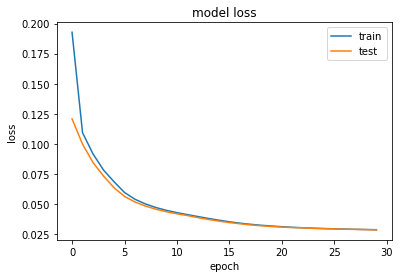

In [17]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [18]:
#autoencoder = load_model('model_seqs2.h5')
print(f'Min Loss:{np.min(history["loss"])}')

Min Loss:0.028820152965188025


### Calculate the Error Term

In [19]:
#get the MSE error term
predictions = autoencoder.predict(scaled_seqs)
mse = np.mean(np.power(scaled_seqs - predictions, 2), axis=1)
print('MSE:', np.quantile(mse, 0.9999)) # => the 9999% quatile - only 0.0001% have error score higher than that


MSE: 0.1946808756859858


### Lets return to the seqs_ds data set that holds all the sequences

In [21]:
seqs_ds[:3]

,0
0,BCBF0RSW
1,CBDF0ZWZ
2,DBFA8XSX


In [23]:
#encode all the data
encoded_seqs = encode_sequence_list(seqs_ds.iloc[:,0])
#scale it with the same fitted transformation!
scaled_data = scaler.transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
# Now we also have the mse for all the 25001 --> 35000 data which are anomalies!
seqs_ds['MSE'] = mse

In [26]:
# Let us create a function that process the sequence through the autoencoder
# and returns the output as a sequence
def test_autoencoder(instring):
    t0 = [instring]
    #print(t0)
    t1 = np.array(encode_sequence_list(t0))
    #print(t1)
    t2 = scaler.transform(t1)
    #print(t2)
    t3 = autoencoder.predict(t2)
    #print(t3)
    t4 = scaler.inverse_transform(t3)
    #print(t4)
    t5 = decode_sequence_list(t4.astype(int))
    #print(t5)
    out = ''.join(t5[0])
    mse = np.mean(np.power(t2 - t3, 2), axis=1)
    return out, round(mse[0],5)

In [27]:
test_autoencoder('AABA8MPT')

('AACB7NRV', 0.04469)

In [28]:
test_autoencoder('PMTT3ABA')

('CDBDvTMQ', 3.5454)

In [29]:
mse_threshold = np.quantile(seqs_ds['MSE'], 0.999)
print(f'MSE 0.9999 threshhold:{mse_threshold}')

MSE 0.9999 threshhold:0.14581492202237048


## Let's compute some AUC curves

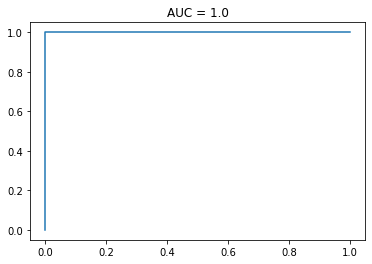

In [30]:
# Let us recall how ROC curve commands work
from sklearn.metrics import roc_auc_score, roc_curve
y_true = np.array([0, 0, 1, 1,1])
y_scores = np.array([0.1, 0.4, 0.75, 0.8,.6])
auc = roc_auc_score(y_true, y_scores)
fpr , tpr, _= roc_curve(y_true, y_scores)
plt.plot(fpr,tpr)
plt.title('AUC = '+str(auc))
plt.show()

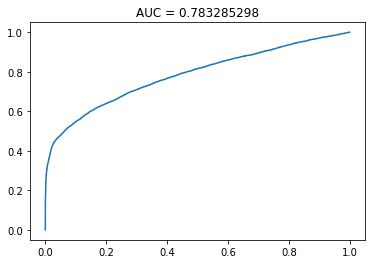

In [31]:
# We define the ytrue and yscore for the AUC
y_true = [0] * 25000 + [1] * 10000
y_scores = seqs_ds['MSE']
# And compute it
auc = roc_auc_score(y_true, y_scores)
fpr , tpr, _= roc_curve(y_true, y_scores)
plt.plot(fpr,tpr)
plt.title('AUC = '+str(auc))
plt.show()

# Home Work

<b>1st case:</b>

first_letters =  'AEF'<br>
second_numbers = '790'<br>
last_letters = 'RSTUZ'<br>
<br>
first_letters2 =  'ABCDEF'<br>
second_numbers2 = '7890'<br>
last_letters2 = 'RSTUVWXYZ'<br>

$\longrightarrow AUC = 0.60$

Observe what a good resolution power it has with only 3 letters missing!

<b>2nd case:</b>

first_letters =  'ABCEF'<br>
second_numbers = '7890'<br>
last_letters = 'RSTVWXYZ'<br>
<br>
first_letters2 =  'ABCDEF'<br>
second_numbers2 = '7890'<br>
last_letters2 = 'RSTUVWXYZ'<br>

$\longrightarrow AUC = 0.43$

$\longrightarrow$ When dropping only one letter in the real data, we see that the auto-encoder learns the pattern regardless if this letter is missing, then the fakes are better classified! Amazing!
